In [73]:
'''
data - колонки main_img, label (multi, single, unknown)

нужен классификатор который (что-то быстрое, но мощное, файнтюн кого-то)
принимает картинку, говорит сколько на ней товаров - много, мало, неизвестно (сюда попадаем, если модель не уверена в много/мало)

обучить с тестом и валидацией, выводить метрики

сохранить классификатор

написать функцию is_multi(model_dir, img_path) -> три вероятности (multi, single, unknown)
при этом она сама выгружает модель из директории

написать функцию is_multi_packimg(model_dir, img_pathes=[]) -> три вероятности (multi, single, unknown)
проверяет каждую картинку, и агрегирует результат, давая его для всего набора переданных картинок
'''


'\ndata - колонки main_img, label (multi, single, unknown)\n\nнужен классификатор который (что-то быстрое, но мощное, файнтюн кого-то)\nпринимает картинку, говорит сколько на ней товаров - много, мало, неизвестно (сюда попадаем, если модель не уверена в много/мало)\n\nобучить с тестом и валидацией, выводить метрики\n\nсохранить классификатор\n\nнаписать функцию is_multi(model_dir, img_path) -> три вероятности (multi, single, unknown)\nпри этом она сама выгружает модель из директории\n\nнаписать функцию is_multi_packimg(model_dir, img_pathes=[]) -> три вероятности (multi, single, unknown)\nпроверяет каждую картинку, и агрегирует результат, давая его для всего набора переданных картинок\n'

In [74]:
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm
import torch.nn as nn
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [75]:
CLASS_NAMES = ['много товаров', 'один товар', 'непонятно']
LABEL2IDX = {name: i for i, name in enumerate(CLASS_NAMES)}
IDX2LABEL = {i: name for name, i in LABEL2IDX.items()}

In [76]:
IMAGES = '/workspace/AAA_project/data/main_dataset/images/'

In [77]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2(),
])



val_transform = A.Compose([
    A.Resize(height=224, width=224),  # Здесь height/width всё ещё работает
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [78]:
class ProductCountDataset(Dataset):
    def __init__(self, df, images_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['main_img']
        if not os.path.isabs(img_path):
            img_path = os.path.join(self.images_dir, img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)['image']
        y = LABEL2IDX[row['label']]
        return img, y

In [79]:
df = pd.read_csv('MULTI-5242-SINGLE-30906-UNKNOWN-1293.csv')
df['main_img'] = df['main_img'].apply(lambda x: str(x) + '.jpg')
df

,item_id,title,description,attrs,images,category,other,main_img,label
0,1322715250286,Туфли Kapika р.30,Новые туфельки для девочки\n\nТМ Kapika \n\nВе...,"{'Вид одежды': 'Для девочек', 'Предмет одежды'...",[14797484977],(Ж) Обувь,"Туфли Kapika для девочек, размер 30 (19 см), в...",14797484977.jpg,один товар
1,1855325000254,Кеды adidas superstar детские,"Продаю кеды адидас, оригинал, покупались в офл...","{'Предмет одежды': 'Обувь', 'Вид одежды': 'Для...","[29690495353, 29690495386, 29690495401, 296904...",(М) Обувь,Продаю детские кеды adidas Superstar белого цв...,29690495386.jpg,один товар
2,1779415000905,Кросовки 27 размер для девочки,Кросовки для девочки от Загадка в хорошем сост...,"{'Вид одежды': 'Для девочек', 'Предмет одежды'...","[27889651299, 27889651322, 27889651235, 278896...",(Ж) Обувь,"Яркие разноцветные кроссовки для девочки, разм...",27889651322.jpg,много товаров
3,1817738751606,Crocs сабо детские35-36/3-5 оригинал,"Состояние отличное, дефект единственный на фот...","{'Вид одежды': 'Для девочек', 'Предмет одежды'...","[28909766974, 28909767030, 28909767120, 289097...",(Ж) Обувь,Продаются оригинальные детские сабо Crocs в яр...,28909767030.jpg,непонятно
4,1863482000525,Ботинки детские Tombi 26 размер,"Ботиночки Tombi,в стиле Timberland,очень удобн...","{'Предмет одежды': 'Обувь', 'Вид одежды': 'Для...","[29898615047, 29898615057, 29898615186]",(М) Обувь,"Продаются детские ботинки Tombi 26 размера, ко...",29898615047.jpg,один товар
...,...,...,...,...,...,...,...,...,...
37436,1663653000236,Кофточки 122,Кофточки для школы.\nЧерная с жемчугом и синяя...,"{'Вид одежды': 'Для девочек', 'Предмет одежды'...","[29413588886, 29413589167]",(Ж) Блузки и рубашки,Продаю стильные кофточки для девочек от бренда...,29413589167.jpg,один товар
37437,1670162501379,Футболка и толстовка для мальчика 152см,Вещи пакетом на мальчика. На рост 152см. Вещи ...,"{'Предмет одежды': 'Футболки и майки', 'Вид од...","[26299714558, 29298404644, 29307635580, 293076...",(М) Футболки и майки,Продаю комплект одежды для мальчика на рост 15...,26299714558.jpg,один товар
37438,1676625251053,Хлопковая фланелевая рубашка hm 68,Новая хлопковая фланелевая рубашка H&M 🇩🇪\n\nC...,"{'Предмет одежды': 'Рубашки', 'Вид одежды': 'Д...","[25538038858, 25538039948]",(М) Рубашки,Новая хлопковая фланелевая рубашка H&M для мал...,25538039948.jpg,один товар
37439,1320192252110,Рубашка для мальчика 140,Рубашка голубого цвета длина рукава 51 ширина ...,"{'Предмет одежды': 'Рубашки', 'Вид одежды': 'Д...",[14744548373],(М) Рубашки,Продаётся новая голубая рубашка для мальчика. ...,14744548373.jpg,один товар


In [80]:
df['label'].value_counts()

label
один товар       30906
много товаров     5242
непонятно         1293
Name: count, dtype: int64

In [81]:
df_multi = df[df['label'] == 'много товаров'].sample(1293, random_state=42)
df_single = df[df['label'] == 'один товар'].sample(1293, random_state=42)
df_unknown = df[df['label'] == 'непонятно'].sample(1293, random_state=42)
df = pd.concat([df_multi, df_single, df_unknown], axis=0)

df['label'].value_counts()

label
много товаров    1293
один товар       1293
непонятно        1293
Name: count, dtype: int64

In [82]:
df = df[df['label'] != 'непонятно']

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

train_ds = ProductCountDataset(train_df, images_dir=IMAGES, transform=train_transform)
val_ds = ProductCountDataset(val_df, images_dir=IMAGES, transform=val_transform)
test_ds = ProductCountDataset(test_df, images_dir=IMAGES, transform=val_transform)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=16)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=16)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=16)

Train: 2068 Val: 259 Test: 259


In [83]:
class ProductCountClassifier(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0.ra_in1k', num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        self.fc = nn.Linear(self.backbone.num_features, num_classes)
    
    def forward(self, x):
        x = self.backbone(x)
        return self.fc(x)

In [84]:
def train_epoch(model, dl, optimizer, criterion, device):
    model.train()
    losses, corrects, total = [], 0, 0
    all_preds, all_labels = [], []
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pred = out.argmax(dim=1)
        corrects += (pred == y).sum().item()
        total += y.size(0)
        all_preds.extend(pred.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())
    
    acc = corrects / total
    return np.mean(losses), acc, np.array(all_preds), np.array(all_labels)

In [85]:
def eval_epoch(model, dl, criterion, device):
    model.eval()
    losses, corrects, total = [], 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            losses.append(loss.item())
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            corrects += (pred == y).sum().item()
            total += y.size(0)
    acc = corrects / total
    return np.mean(losses), acc, np.array(all_preds), np.array(all_labels)

In [86]:
def plot_metrics(history):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    axs[0].plot(history['train_loss'], label='Train')
    axs[0].plot(history['val_loss'], label='Validation')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(history['train_acc'], label='Train')
    axs[1].plot(history['val_acc'], label='Validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    axs[2].plot(history['train_f1'], label='Train')
    axs[2].plot(history['val_f1'], label='Validation')
    axs[2].set_title('F1 Score')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.suptitle('Training and Validation Metrics')
    plt.tight_layout()
    plt.show()

In [87]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ProductCountClassifier('convnext_xlarge', num_classes=3).to(device)
# model = ProductCountClassifier('efficientnet_b0', num_classes=3).to(device)
# model = ProductCountClassifier('resnet50.a1_in1k', num_classes=3).to(device)

# model = ProductCountClassifier('swin_base_patch4_window7_224.ms_in1k', num_classes=3).to(device)
model = ProductCountClassifier().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=3)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

criterion = nn.CrossEntropyLoss()

In [88]:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

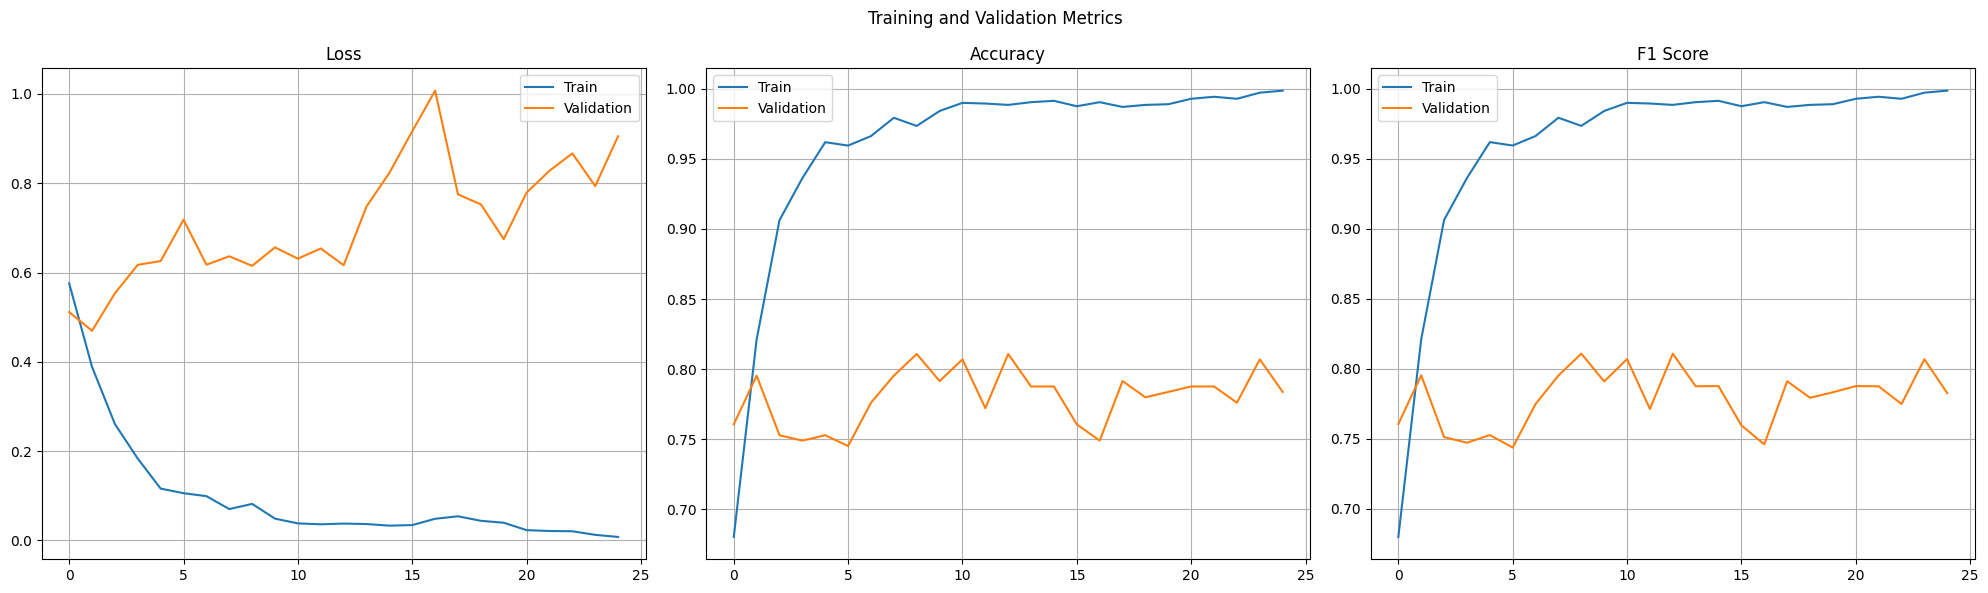

Epoch 25/10
Train Loss: 0.0078 | Acc: 0.9985 | F1: 0.9985
Val Loss:   0.9052 | Acc: 0.7838 | F1: 0.7826



In [89]:
from IPython.display import clear_output
import time

best_val_f1 = 0.0
os.makedirs('product_count_model', exist_ok=True)

for epoch in range(25):
    train_loss, train_acc, train_preds, train_labels = train_epoch(
        model, train_dl, optimizer, criterion, device
    )
    val_loss, val_acc, val_preds, val_labels = eval_epoch(
        model, val_dl, criterion, device
    )
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_f1'].append(f1_score(train_labels, train_preds, average='macro'))
    history['val_f1'].append(f1_score(val_labels, val_preds, average='macro'))
    
    plot_metrics(history)
    time.sleep(0.5) 
    
    print(f"Epoch {epoch+1}/10")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {history['train_f1'][-1]:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {history['val_f1'][-1]:.4f}\n")

    if history['val_f1'][-1] > best_val_f1:
        best_val_f1 = history['val_f1'][-1]
        torch.save(model.state_dict(), 'product_count_model/model.pt')

    scheduler.step(history['val_f1'][-1])

In [90]:
model.load_state_dict(torch.load('product_count_model/model.pt'))


test_loss, test_acc, test_preds, test_labels = eval_epoch(model, test_dl, criterion, device)
test_f1 = f1_score(test_labels, test_preds, average='macro')

print("\nTest Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | F1: {test_f1:.4f}")

CLASS_NAMES.remove('непонятно')

print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))
print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))


Test Results:
Loss: 0.8021 | Accuracy: 0.7761 | F1: 0.7753
               precision    recall  f1-score   support

много товаров       0.75      0.83      0.79       130
   один товар       0.81      0.72      0.76       129

     accuracy                           0.78       259
    macro avg       0.78      0.78      0.78       259
 weighted avg       0.78      0.78      0.78       259

Confusion Matrix:
 [[108  22]
 [ 36  93]]


In [91]:


''' ИНФЕРЕНС
from torchvision import transforms


def is_multi(model_dir, img_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ProductCountClassifier('convnext_xlarge', num_classes=3).to(device)
    model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'), map_location=device))
    model.eval()
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    x = tfm(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
    return {name: float(probs[i]) for i, name in enumerate(CLASS_NAMES)}


def is_multi_packimg(model_dir, img_pathes):
    probs_sum = np.zeros(3, dtype=np.float32)
    for img_path in img_pathes:
        probs = is_multi(model_dir, img_path)
        probs_sum += np.array([probs[name] for name in CLASS_NAMES])
    probs_avg = probs_sum / len(img_pathes)
    return {name: float(probs_avg[i]) for i, name in enumerate(CLASS_NAMES)}
'''

" ИНФЕРЕНС\nfrom torchvision import transforms\n\n\ndef is_multi(model_dir, img_path):\n    device = 'cuda' if torch.cuda.is_available() else 'cpu'\n    model = ProductCountClassifier('convnext_xlarge', num_classes=3).to(device)\n    model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'), map_location=device))\n    model.eval()\n    tfm = transforms.Compose([\n        transforms.Resize((224, 224)),\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),\n    ])\n    img = Image.open(img_path).convert('RGB')\n    x = tfm(img).unsqueeze(0).to(device)\n    with torch.no_grad():\n        out = model(x)\n        probs = torch.softmax(out, dim=1).cpu().numpy()[0]\n    return {name: float(probs[i]) for i, name in enumerate(CLASS_NAMES)}\n\n\ndef is_multi_packimg(model_dir, img_pathes):\n    probs_sum = np.zeros(3, dtype=np.float32)\n    for img_path in img_pathes:\n        probs = is_multi(model_dir, img_path)\n        probs_s